# Predicting US tornados' magnitude

**Goal**:

The main goal is to explore the US Tornado data by performing exploratory data analysis and try to predict tornado magnitude by building machine learning models.

**Data**: 

The data is from NOAA and can be found on https://www.kaggle.com/datasets/sujaykapadnis/tornados.

Tornadoes can be among the most violent phenomena of all storms that can be experienced. Tornadoes occur in many parts of the world but the highest concentrations of tornadoes occur in the US. Tornados are categorized by according to their magnitude scale with ratings from 0-5, where 0 means a weak tornado while 5 means a catastrophic tornado.

In [1]:
# Import libraries and packages

import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
from matplotlib import pyplot as plt
from matplotlib.patches import FancyBboxPatch
import plotly.express as px
from matplotlib.ticker import FuncFormatter

from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer, classification_report, precision_recall_fscore_support, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read in data
df0 = pd.read_csv('/kaggle/input/tornados/tornados.csv')

# EDA

In [3]:
# Create a df copy
df = df0.copy()
# Check the first 5 rows
df.head()

,om,yr,mo,dy,date,time,tz,datetime_utc,st,stf,...,elon,len,wid,ns,sn,f1,f2,f3,f4,fc
0,192,1950,10,1,1950-10-01,21:00:00,America/Chicago,1950-10-02T03:00:00Z,OK,40,...,-102.3,15.8,10,1,1,25,0,0,0,False
1,193,1950,10,9,1950-10-09,02:15:00,America/Chicago,1950-10-09T08:15:00Z,NC,37,...,0.0,2.0,880,1,1,47,0,0,0,False
2,195,1950,11,20,1950-11-20,02:20:00,America/Chicago,1950-11-20T08:20:00Z,KY,21,...,0.0,0.1,10,1,1,177,0,0,0,False
3,196,1950,11,20,1950-11-20,04:00:00,America/Chicago,1950-11-20T10:00:00Z,KY,21,...,0.0,0.1,10,1,1,209,0,0,0,False
4,197,1950,11,20,1950-11-20,07:30:00,America/Chicago,1950-11-20T13:30:00Z,MS,28,...,0.0,2.0,37,1,1,101,0,0,0,False


In [4]:
# Check the data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68693 entries, 0 to 68692
Data columns (total 27 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   om            68693 non-null  int64  
 1   yr            68693 non-null  int64  
 2   mo            68693 non-null  int64  
 3   dy            68693 non-null  int64  
 4   date          68693 non-null  object 
 5   time          68693 non-null  object 
 6   tz            68693 non-null  object 
 7   datetime_utc  68693 non-null  object 
 8   st            68693 non-null  object 
 9   stf           68693 non-null  int64  
 10  mag           67937 non-null  float64
 11  inj           68693 non-null  int64  
 12  fat           68693 non-null  int64  
 13  loss          41523 non-null  float64
 14  slat          68693 non-null  float64
 15  slon          68693 non-null  float64
 16  elat          68693 non-null  float64
 17  elon          68693 non-null  float64
 18  len           68693 non-nu

There are 68693 rows and 27 columns. There are 1 boolean, 7 float, 14 integer and 5 object data types in this dataset. There are missing values in 'mag' and 'loss' columns which will be summarized separately.

In [5]:
# Check for duplicates
df.duplicated().sum()

1

There is one duplicate and it is assumed that it can be dropped.

In [6]:
# Drop duplicate row
df.drop_duplicates(inplace = True)

In [7]:
# Check missing values by column
df.isna().sum()

om                  0
yr                  0
mo                  0
dy                  0
date                0
time                0
tz                  0
datetime_utc        0
st                  0
stf                 0
mag               756
inj                 0
fat                 0
loss            27170
slat                0
slon                0
elat                0
elon                0
len                 0
wid                 0
ns                  0
sn                  0
f1                  0
f2                  0
f3                  0
f4                  0
fc                  0
dtype: int64

In [8]:
# Check the missing values of 'mag'
df['mag'].value_counts(dropna = False)

mag
0.0    31772
1.0    23328
2.0     9636
3.0     2556
NaN      756
4.0      585
5.0       59
Name: count, dtype: int64

The target variable of 'mag' (magnitude) is highly imbalanced and this can bring a great challenge to the classification algorithms.

In [9]:
# Gather basic statistics
df.describe()

,om,yr,mo,dy,stf,mag,inj,fat,loss,slat,...,elat,elon,len,wid,ns,sn,f1,f2,f3,f4
count,68692.000000,68692.000000,68692.000000,68692.000000,68692.000000,67936.000000,68692.000000,68692.000000,4.152200e+04,68692.000000,...,68692.000000,68692.000000,68692.000000,68692.000000,68692.000000,68692.000000,68692.000000,68692.000000,68692.000000,68692.000000
mean,113194.574172,1991.853724,5.968541,15.930822,29.220404,0.778718,1.418710,0.089312,2.020940e+06,37.129332,...,22.960391,-56.835589,3.489279,107.768474,1.008764,0.991411,104.644646,8.605267,1.687227,0.506798
std,226615.695929,19.565101,2.444674,8.750120,15.013332,0.895796,18.114883,1.472131,3.039625e+07,5.099023,...,18.528154,45.340872,8.247175,206.852655,0.095060,0.092279,96.750829,38.106282,16.681785,9.163261
min,1.000000,1950.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,5.000000e+01,17.721200,...,0.000000,-163.530000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,285.000000,1976.000000,4.000000,8.000000,18.000000,0.000000,0.000000,0.000000,1.000000e+04,33.180000,...,0.000000,-94.780000,0.120000,20.000000,1.000000,1.000000,37.000000,0.000000,0.000000,0.000000
50%,588.000000,1995.000000,6.000000,16.000000,28.000000,1.000000,0.000000,0.000000,5.000000e+04,37.000000,...,32.550000,-84.720000,0.800000,50.000000,1.000000,1.000000,85.000000,0.000000,0.000000,0.000000
75%,1117.250000,2008.000000,7.000000,24.000000,42.000000,1.000000,0.000000,0.000000,5.000000e+05,40.920000,...,38.650000,0.000000,3.210000,100.000000,1.000000,1.000000,137.000000,0.000000,0.000000,0.000000
max,622080.000000,2022.000000,12.000000,31.000000,78.000000,5.000000,1740.000000,158.000000,2.800100e+09,61.020000,...,61.020000,0.000000,234.700000,4576.000000,3.000000,1.000000,810.000000,820.000000,710.000000,507.000000


Some columns have max values that are multiple standard deviations above the 75th percentile. This could indicate outliers. The variables are also at  a different scale.

Let's check where tornados occur in the US.

In [10]:
# Plot tornado occurencies
fig = px.scatter_geo(df, lat = 'slat', lon = 'slon', color = 'mag', width = 800, height = 400, color_continuous_scale=px.colors.sequential.Aggrnyl)
fig.update_layout(title=dict(text = 'US Tornado occurencies (1950-2022) ', x = 0.5), geo_scope='usa')
fig.update_traces(marker=dict(size=1), showlegend=False)
fig.show()

Tornados occur in all US states but the most of them occure from the middle to the east states.

In [11]:
# Check distinct years
df['yr'].unique()

array([1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960,
       1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2020, 2021, 2022])

All year from 1950 to 2022 appear in the dataset without any gap.

Text(0, 0.5, '')

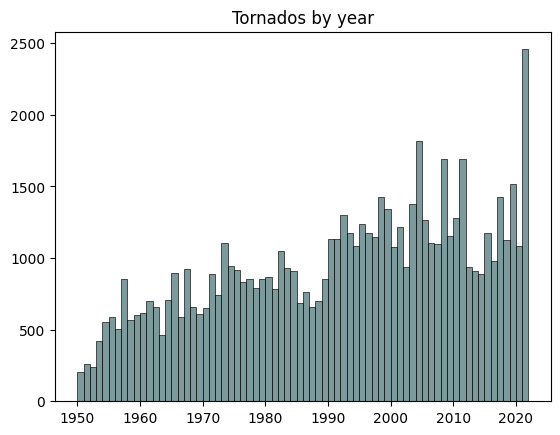

In [12]:
# Histogram of years
sns.histplot(df, x = 'yr', bins = 72, color = '#50777b').set(title='Tornados by year')
plt.xlabel('')
plt.ylabel('')

The graph shows that the number of tornado occurencies seems to be increasing over time.

But does all tornado magnitude show the same trend?

Text(0, 0.5, '')

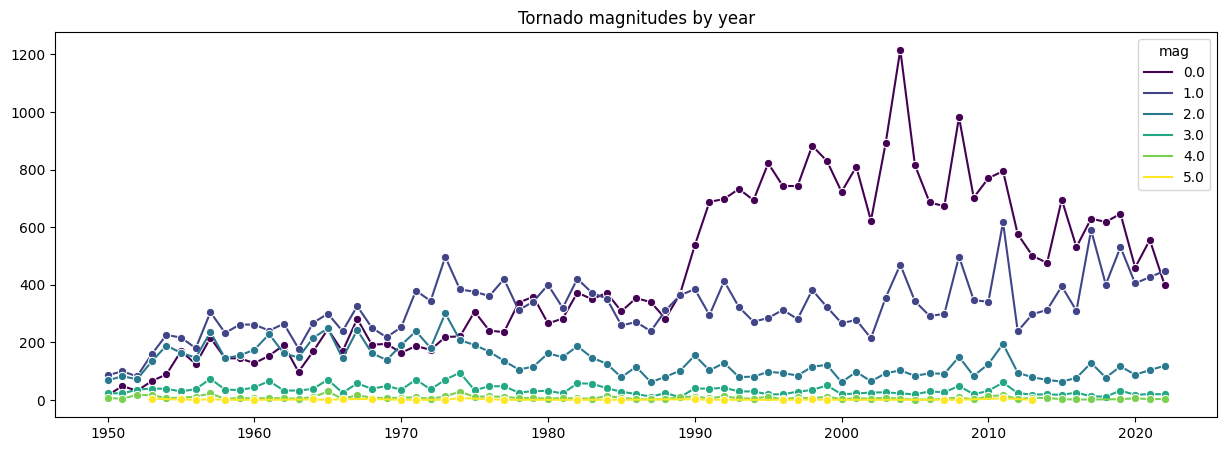

In [13]:
# Plot tornados by year and magnitude
to = df.groupby(['yr', 'mag'])['yr'].count().reset_index(name = 'Count')
plt.figure(figsize = (15, 5)) 
sns.lineplot(data=to, x='yr', y='Count', hue='mag', marker='o', palette = 'viridis').set(title = 'Tornado magnitudes by year')
plt.xlabel('')
plt.ylabel('')

At a first glance, the tornadoes shows a strong upward trend where magnitude is 0 and 1 until the begining of 2000s, a slight downward trend when magnitude is 2 and no significant change when magnitude is 3, 4, 5.

In [14]:
# Check distinct months
m = df['mo'].unique()
print(sorted(m))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


Data is avalailable for all 12 months without any gap.

Text(0, 0.5, '')

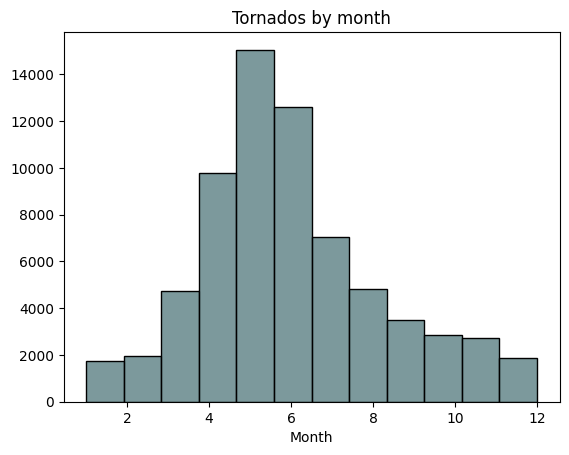

In [15]:
# Histogram of months
sns.histplot(df, x = 'mo', bins = 12, color = '#50777b').set(title='Tornados by month')
plt.xlabel('Month')
plt.ylabel('')

The graph shows that most tornados likley tend to occure in May and June.

In [16]:
# Check distinct days
d = df['dy'].unique()
print(sorted(d))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


Real calendar days are listed without any gap.

Text(0, 0.5, '')

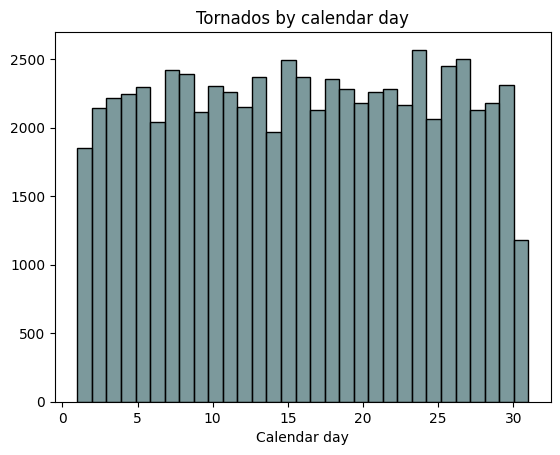

In [17]:
# Histogram of days
sns.histplot(df, x = 'dy', bins = 31, color = '#50777b').set(title='Tornados by calendar day')
plt.xlabel('Calendar day')
plt.ylabel('')

The graph shows that day data is evenly distributed. Only 7 months have 31 calendar days this is why the frequency is less on that day.

In [18]:
# Time lineplot
t = df.groupby(['time'])['time'].count().reset_index(name = 'count')
fig = px.line(t, x='time', y='count', title = 'Tornado occurencies by time of day', template='simple_white')
fig.update_traces(line_color='#50777b', line_width=0.5)
fig.update_layout(title_text='Tornado occurencies by time of day', title_x=0.5)

Tornadoes can happen at any time but most tornadoes seem to occure at afternoon and evening hours.

In [19]:
# The most frequent tornado time zones
df['tz'].value_counts()

tz
America/Chicago    68663
America/Denver        28
UTC                    1
Name: count, dtype: int64

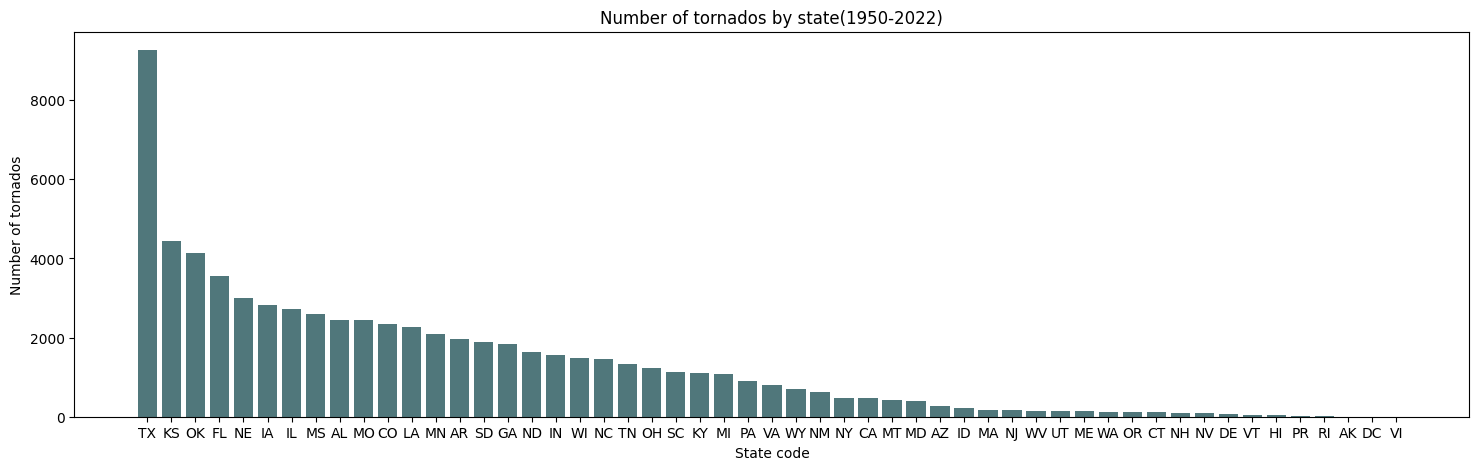

In [20]:
# Tornados by state
plt.figure(figsize = (18, 5)) 
plt.bar(x = df['st'].value_counts().index, height = df['st'].value_counts().values, color = '#50777b')
plt.xlabel("State code")
plt.ylabel("Number of tornados")
plt.title("Number of tornados by state(1950-2022)")
plt.show()

Texas is the most heavily hit by tornados comparing to other states. 

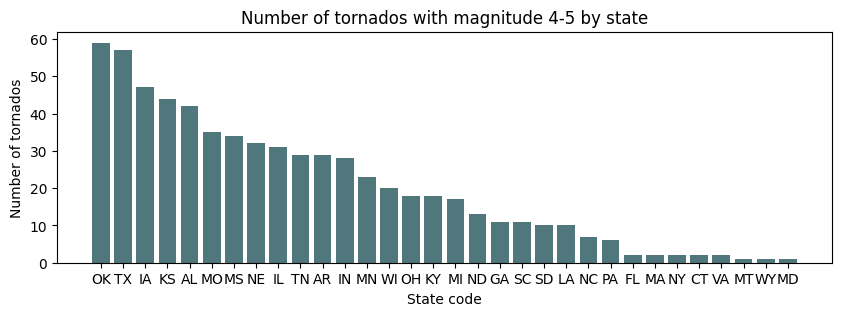

In [21]:
# Comparing tornados' magnitude by state
strongest = df[(df['mag'] == 5.0) | (df['mag'] == 4.0) ]
plt.figure(figsize = (10, 3)) 
plt.bar(x = strongest['st'].value_counts().index, height = strongest['st'].value_counts().values, color = '#50777b')
plt.xlabel('State code')
plt.ylabel('Number of tornados')
plt.title('Number of tornados with magnitude 4-5 by state')
plt.show()

The most strongest tornados, with 4-5 magnitude scale, occure in Oklahoma, followed by Texas, Iowa, Kansas and Alabama.

In [22]:
# Checking the mean tornado length and width according to the magnitude:
len_wid = df.groupby(['mag'])[['len', 'wid']].mean().reset_index()
len_wid

,mag,len,wid
0,0.0,1.104132,45.749685
1,1.0,3.327243,112.892275
2,2.0,7.124990,195.465338
3,3.0,15.124218,384.346635
4,4.0,28.132547,621.164103
5,5.0,39.007797,839.067797


It seems like the more powerful the tornado, the longer and wider its path.

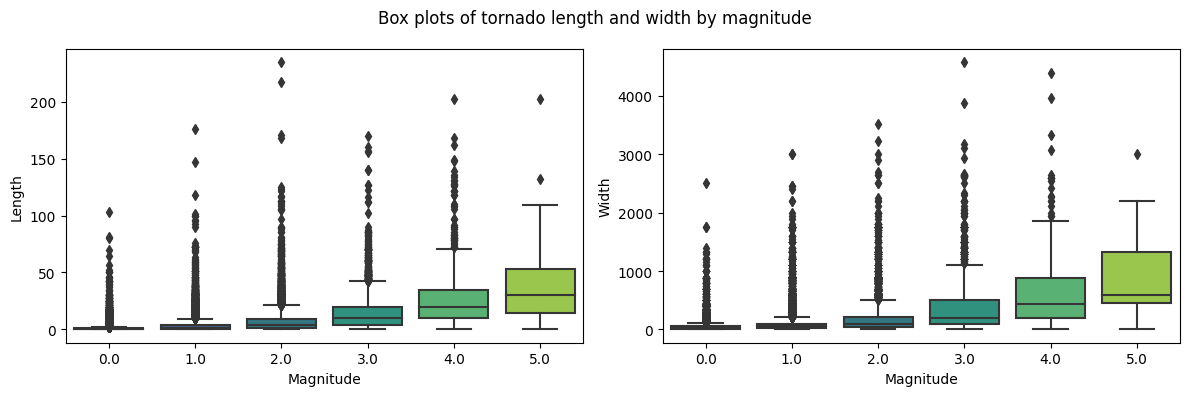

In [23]:
# Plot to compare tornado length and width by magnitude
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Box plots of tornado length and width by magnitude')
sns.boxplot(ax=axes[0], x=df['mag'], y = df['len'], palette = 'viridis').set(xlabel='Magnitude', ylabel = 'Length')    
sns.boxplot(ax=axes[1], x=df['mag'], y = df['wid'], palette = 'viridis').set(xlabel='Magnitude', ylabel = 'Width')   
plt.tight_layout()
plt.show()

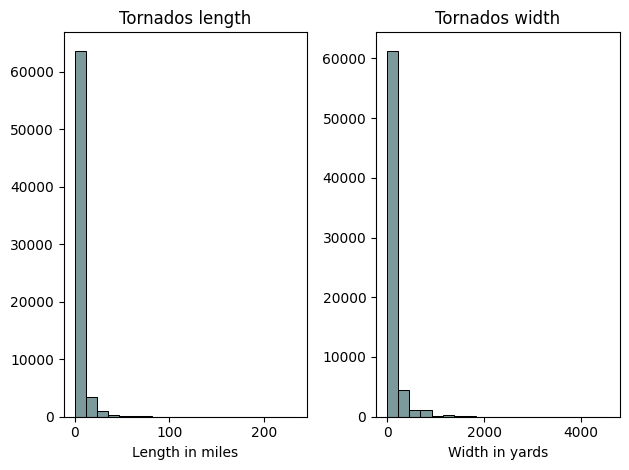

In [24]:
# Histograms of length and width
fig, axes = plt.subplots(1, 2)
sns.histplot(ax=axes[0], x = df['len'], bins = 20, color = '#50777b').set(title='Tornados length', xlabel = 'Length in miles', ylabel = '')
sns.histplot(ax=axes[1], x = df['wid'], bins = 20, color = '#50777b').set(title='Tornados width', xlabel = 'Width in yards', ylabel = '')
plt.tight_layout()
plt.show()

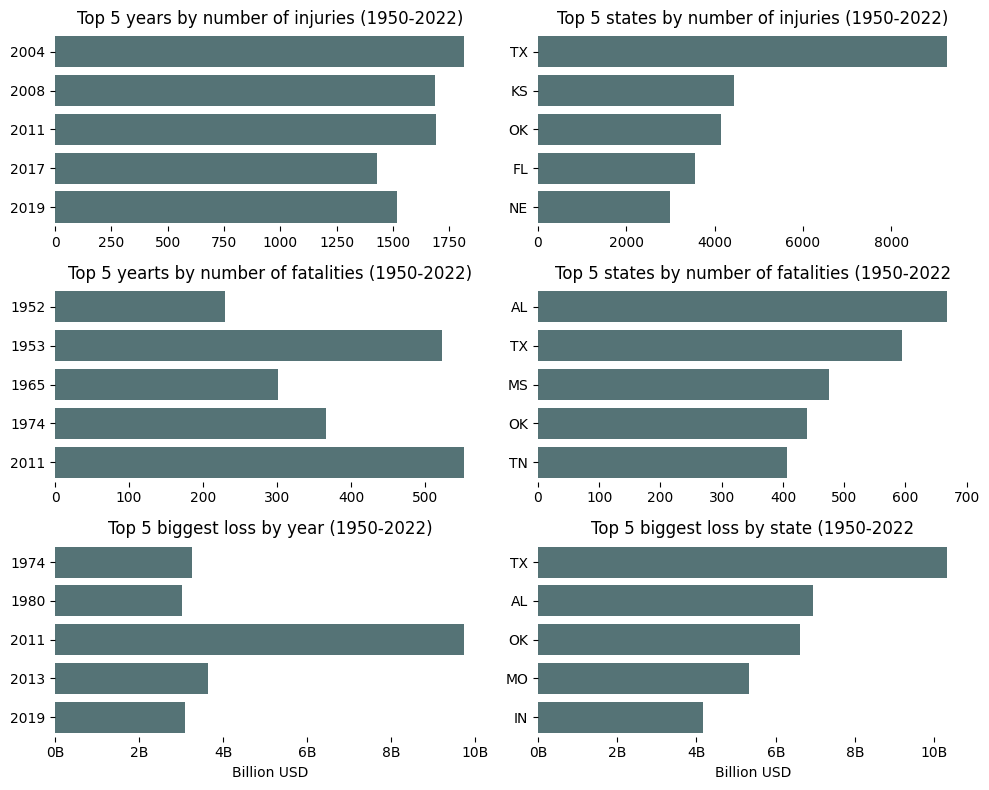

In [25]:
inj_year = df.yr.value_counts()[ :5].rename_axis().reset_index(name='counts')
inj_state = df.st.value_counts()[ :5].rename_axis().reset_index(name='counts')
fat_year = df.groupby(['yr']).sum(numeric_only = True)['fat'].rename_axis().reset_index(name='counts').sort_values(['counts'], ascending = False)[ :5]
fat_state = df.groupby(['st']).sum(numeric_only = True)['fat'].rename_axis().reset_index(name='counts').sort_values(['counts'], ascending = False)[ :5]
loss_year = df.groupby(['yr']).sum(numeric_only = True)['loss'].rename_axis().reset_index(name='counts').sort_values(['counts'], ascending = False)[ :5]
loss_state = df.groupby(['st']).sum(numeric_only = True)['loss'].rename_axis().reset_index(name='counts').sort_values(['counts'], ascending = False)[ :5]

fig, axes = plt.subplots(3, 2, figsize=(10, 8))

sns.barplot(ax=axes[0,0], data=inj_year, x='counts', y='yr', color = '#50777b', orient='h')
axes[0,0].set_title('Top 5 years by number of injuries (1950-2022)')
axes[0,0].set_ylabel('')    
axes[0,0].set_xlabel('')

sns.barplot(ax=axes[0,1], data=inj_state, x='counts', y='st', color = '#50777b', orient='h')
axes[0,1].set_title('Top 5 states by number of injuries (1950-2022)')
axes[0,1].set_ylabel('')    
axes[0,1].set_xlabel('')

sns.barplot(ax=axes[1,0], data=fat_year, x='counts', y='yr', color = '#50777b', orient='h')
axes[1,0].set_title('Top 5 yearts by number of fatalities (1950-2022)')
axes[1,0].set_ylabel('')    
axes[1,0].set_xlabel('')

sns.barplot(ax=axes[1,1], data=fat_state, x='counts', y='st', color = '#50777b', orient='h')
axes[1,1].set_title('Top 5 states by number of fatalities (1950-2022')
axes[1,1].set_ylabel('')    
axes[1,1].set_xlabel('')

sns.barplot(ax=axes[2,0], data=loss_year, x='counts', y='yr', color = '#50777b', orient='h')
axes[2,0].set_title('Top 5 biggest loss by year (1950-2022)')
f = lambda x, pos: f'{x/10**9:,.0f}B'
axes[2,0].xaxis.set_major_formatter(FuncFormatter(f))
axes[2,0].set_ylabel('')    
axes[2,0].set_xlabel('Billion USD')

sns.barplot(ax=axes[2,1], data=loss_state, x='counts', y='st', color = '#50777b', orient='h')
axes[2,1].set_title('Top 5 biggest loss by state (1950-2022')
f = lambda x, pos: f'{x/10**9:,.0f}B'
axes[2,1].xaxis.set_major_formatter(FuncFormatter(f))
axes[2,1].set_ylabel('')    
axes[2,1].set_xlabel('Billion USD')

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

2011 was oustanding in terms of injuries, fatalities and loss in USD. As it was observed earlier, Texas, Alabama and Oklahoma suffered the most.

# Feature engineering

Instead of trasforming date and time to ordinal I have decided to use 'yr', 'mo', 'dy' columns that already have numerical data types. Also, new columns are to be created for time ('hour', 'mins').

In [26]:
# Create a datetime 'hour' column
df['hour'] = pd.to_datetime(df['time'])
# Convert'hour' column
df['hour'] = df['hour'].dt.hour
# Create a datetime 'mins' column
df['mins'] = pd.to_datetime(df['time'])
# Convert'hour' column
df['mins'] = df['mins'].dt.minute
df.head(2)

,om,yr,mo,dy,date,time,tz,datetime_utc,st,stf,...,wid,ns,sn,f1,f2,f3,f4,fc,hour,mins
0,192,1950,10,1,1950-10-01,21:00:00,America/Chicago,1950-10-02T03:00:00Z,OK,40,...,10,1,1,25,0,0,0,False,21,0
1,193,1950,10,9,1950-10-09,02:15:00,America/Chicago,1950-10-09T08:15:00Z,NC,37,...,880,1,1,47,0,0,0,False,2,15


The variable 'loss' has a big scale comparing to other columns therefore a log-transformation is going to be made to have a more normally distribution.

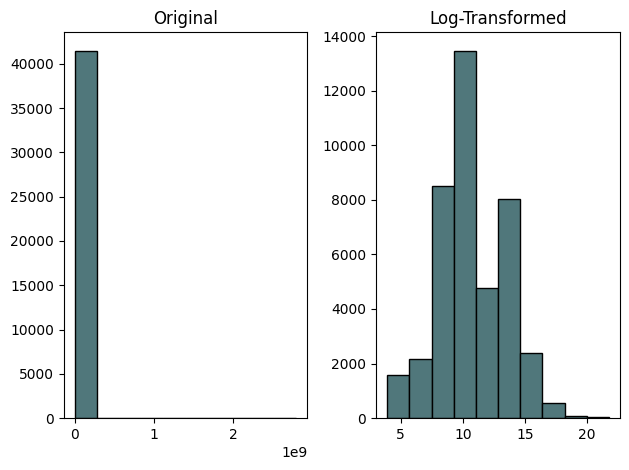

In [27]:
# Create log-transformed data
df['log_loss'] = np.log(df['loss'])

# Define grid of plots
fig, axs = plt.subplots(nrows=1, ncols=2)

# Create histograms
axs[0].hist(df['loss'], color = '#50777b', edgecolor='black')
axs[1].hist(df['log_loss'], color = '#50777b', edgecolor='black')

# Add title to each histogram
axs[0].set_title('Original')
axs[1].set_title('Log-Transformed')

plt.tight_layout()
plt.show()

As it was observed earlier there are missing values in 'loss' column which was log-transformed hence 'log_loss' also has missing values.

In [28]:
# Number of missing values in 'log_loss'
print('Number of missing values in log_loss column:',df['log_loss'].isna().sum())

Number of missing values in log_loss column: 27170


The original 'loss' column has many outliers statistically but most likely these are not real outliers beacuse strong and rare tornados can cause outstaning financial loss. For this reason it was decided to replace the missing values by 0 in both 'loss' and 'log_loss' columns.

In [29]:
# Impute missing values by 0
df['loss'] = df['loss'].fillna(0)
df['log_loss'] = df['log_loss'].fillna(0)

# Gather statistics for 'log_loss'
df['log_loss'].describe()

count    68692.000000
mean         6.515430
std          5.668668
min          0.000000
25%          0.000000
50%          8.517193
75%         10.819778
max         21.752921
Name: log_loss, dtype: float64

In [30]:
# Number of missing values in 'mag'
print('Number of missing values in mag column:',df['mag'].isna().sum())

Number of missing values in mag column: 756


Missing values should be addressed to the data owner but in this case it is assumed that rows with missing magnitude values can be dropped.

In [31]:
# Drop Nan values
df = df.dropna()

# Feature selection

The following columns will be dropped: 'om', 'yr', 'date', 'time', 'tz', 'datetime_utc', 'st', 'loss', 'elat', 'elon', 'ns', 'sn', 'f1', 'f2', 'f3', 'f4', 'fc' because these wouldn't expect to offer any predictive signal to the models. 

Instead of using the date and time columns, only the numerical 'mo'(month), 'dy'(day) and the recently created 'hour' and 'mins' columns will be included. 'yr' (year) also shouldn't be used because presumably a predictive model can be used in the future and those future years wouldn’t be included and trained in this dataset.

The column of 'st'(state) will be also discarded beacuse 'stf'(state FIPS) is already a numerical variable for states.

'loss' is already log-transformed into 'log_loss' and this latter one will be included into the new subset.

In [32]:
# Create a subset
df_subset = df.drop(['om', 'yr', 'date', 'time', 'tz', 'datetime_utc', 'st', 'loss', 'elat', 'elon', 'ns', 'sn', 'f1', 'f2', 'f3', 'f4', 'fc'], axis = 1)
df_subset.head(2)

,mo,dy,stf,mag,inj,fat,slat,slon,len,wid,hour,mins,log_loss
0,10,1,40,1.0,0,0,36.73,-102.52,15.8,10,21,0,10.819778
1,10,9,37,3.0,3,0,34.17,-78.60,2.0,880,2,15,13.122363



# Split the data

The data will be split into features and target variable. The target variable is 'mag' (magnitude) that have 6 higly imbalanced classes (0-5) .

In [33]:
#  Define the target variable
y = df_subset['mag']
# Define the predictor variables
X = df_subset.drop('mag', axis = 1)

Class=1, n=23328 (34.338%)
Class=3, n=2556 (3.762%)
Class=2, n=9636 (14.184%)
Class=4, n=585 (0.861%)
Class=0, n=31772 (46.768%)
Class=5, n=59 (0.087%)


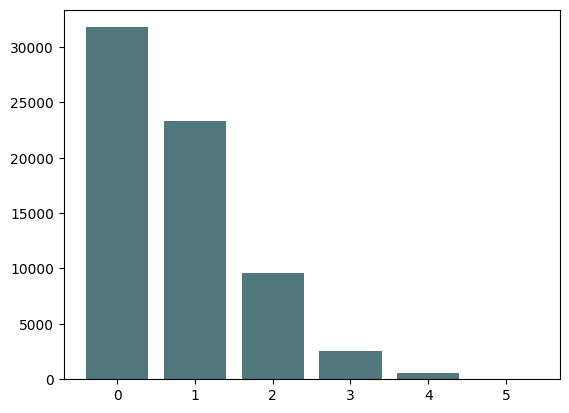

In [34]:
# Class imbalance
counter = Counter(y)
for k,v in counter.items():
 per = v / len(y) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values(), color = '#50777b')
plt.show()

The stratify=y parameter will be included, as this is what ensures that the original class ratios of the target variable is maintained in both the training and test datasets after splitting. Lastly, a random seed will be set to ensure reproducability.

In [35]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# Modeling

Predicting tornado magnitude is a classifiction task therefore Decision Tree and Random Forest models are going to be built beacuse these models are resistant to outliers and they don't require scaling. 

**Metrics**

Since this is a multiclass problem, balanced accuracy will be used as metric along with a classification report. The best value of balanced accuracy is 1 and the worst value is 0 when adjusted=False default option is selected. The balanced accuracy in multiclass classification problems deals with imbalanced datasets. It is defined as the average of recall obtained on each class.

**Baseline Decision Tree**

A decision tree is a flow chart like supervised classification model and a representation of various solutions that are available to solve a given problem based on the possible outcomes of related choices. 

Advantages of decision trees that they require relatively few pre-processing steps, they can work easily with all types of variables (continuous, categorical, discrete), they do not require normalization or scaling, they are transparent and not affected by extreme univariate values.

One of the approach to addressing the problem of class imbalance is to use 'class_weight = 'balanced'' option. T

First a baseline model will be trained, just to get a sense of how predictive the data is and to give scores that can be referenced later. 

In [36]:
# Train the Decision Tree model on the imbalanced dataset
dt = DecisionTreeClassifier(random_state = 0, class_weight = 'balanced').fit(X_train,y_train)
# Baseline model prediction
y_pred = dt.predict(X_test)
# Evaluation metrics
print(classification_report(y_test, y_pred))
print("Balanced accuracy:", "%.3f" % balanced_accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.74      0.73      0.74      7943
         1.0       0.51      0.50      0.50      5832
         2.0       0.33      0.34      0.33      2409
         3.0       0.28      0.28      0.28       639
         4.0       0.28      0.31      0.30       146
         5.0       0.23      0.20      0.21        15

    accuracy                           0.58     16984
   macro avg       0.39      0.39      0.39     16984
weighted avg       0.58      0.58      0.58     16984

Balanced accuracy: 0.394


In [37]:
dt_result = list( precision_recall_fscore_support(y_test, y_pred, average='weighted'))
dt_acc = np.array(balanced_accuracy_score(y_test, y_pred))
# Create a result dataframe
dt_results = pd.DataFrame({'model': ['Decision Tree baseline'],
                           'balanced accuracy': ["{:.6f}".format(dt_acc)],
                           'precision': [dt_result [0]],
                           'recall': [dt_result [1]],
                           'f1_score': [dt_result [2]]
                           })
dt_results

,model,balanced accuracy,precision,recall,f1_score
0,Decision Tree baseline,0.394360,0.578391,0.57613,0.577226


The baseline decision tree model is good at scoring magnitude 0 but its performace drops strongly with the other classes. Its balanced accuracy is very poor.

**DecisionTree CV**

GridSearchCV systematically checking every combination of hyperparameters to identify which set produces the best results, based on the selected metric. The best parameters that GridSearchCV identifies are technically the best that could be produced, but only by the parameters that are included in the parameter grid.

When the fit() method is being used on the GridSearch object, it partitions the data into a user-specified number of folds, fits a model to the non-holdout data (all folds except one), and evaluates it against the holdout fold. Scores on each fold and a mean final score are captured for inspection. 

Advantage of GridSearchCV is that it is faster and less computationally expensive than a multi-fold (k-fold) cross-validation. 

In [38]:
# Hyperparameters
tree_para = {'max_depth':[1,2,3,4,5,6,7,8,9,10,11,20,30,40,50],
             'min_samples_leaf': [2,3, 5,6,8,9, 15, 20, 50]}
# Instantiate the model classifier
cv = DecisionTreeClassifier(random_state=2)
# Instantiate the GridSearchCV object
dt_cv = GridSearchCV(dt, tree_para, cv=5)

In [39]:
%%time
# Fit the model 
dt_cv.fit(X_train, y_train)

CPU times: user 2min 58s, sys: 52.8 ms, total: 2min 58s
Wall time: 2min 59s


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=0),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 20,
                                       30, 40, 50],
                         'min_samples_leaf': [2, 3, 5, 6, 8, 9, 15, 20, 50]})

In [40]:
# Examine best score
print(f'Best score:', dt_cv.best_score_)
# Examine best hyperparameter combination
print(f'Best parameters: ', dt_cv.best_estimator_)

Best score: 0.583235195017559
Best parameters:  DecisionTreeClassifier(class_weight='balanced', max_depth=11,
                       min_samples_leaf=3, random_state=0)


In [41]:
# Get scores on test data
y_pred = dt_cv.best_estimator_.predict(X_test)
# Evaluation metrics
print(classification_report(y_test, y_pred))
print("Balanced accuracy:", "%.3f" % balanced_accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.74      0.78      7943
         1.0       0.55      0.50      0.53      5832
         2.0       0.32      0.36      0.34      2409
         3.0       0.19      0.45      0.27       639
         4.0       0.16      0.40      0.23       146
         5.0       0.07      0.13      0.09        15

    accuracy                           0.59     16984
   macro avg       0.35      0.43      0.37     16984
weighted avg       0.63      0.59      0.61     16984

Balanced accuracy: 0.431


In [42]:
dt_cv_result = list( precision_recall_fscore_support(y_test, y_pred, average='weighted'))
dt_cv_acc = np.array(balanced_accuracy_score(y_test, y_pred))
# Create a result dataframe
dt_cv_results = pd.DataFrame({'model': ['Decision Tree cv'],
                           'balanced accuracy': ["{:.6f}".format(dt_cv_acc)],
                           'precision': [dt_cv_result [0]],
                           'recall': [dt_cv_result [1]],
                           'f1_score': [dt_cv_result [2]]
                           })
results = pd.concat([dt_results, dt_cv_results], axis = 0)
results

,model,balanced accuracy,precision,recall,f1_score
0,Decision Tree baseline,0.394360,0.578391,0.576130,0.577226
0,Decision Tree cv,0.430725,0.631874,0.589908,0.606687


The Decision Tree cv model's overall performace slightly improved comparing to the Decision Tree baseline model but its performace is still weak.

**Random forest**

In [43]:
# Train the Random Forest model using the imbalanced dataset
rf = RandomForestClassifier(class_weight = 'balanced', random_state = 3).fit(X_train,y_train)
# Baseline model prediction
y_pred = rf.predict(X_test)
# Evaluation metrics
print(classification_report(y_test, y_pred))
print("Balanced accuracy:", "%.3f" % balanced_accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.80      0.83      0.82      7943
         1.0       0.58      0.68      0.63      5832
         2.0       0.50      0.34      0.41      2409
         3.0       0.49      0.23      0.31       639
         4.0       0.51      0.27      0.35       146
         5.0       1.00      0.27      0.42        15

    accuracy                           0.68     16984
   macro avg       0.65      0.43      0.49     16984
weighted avg       0.67      0.68      0.67     16984

Balanced accuracy: 0.434


In [44]:
rf_result = list( precision_recall_fscore_support(y_test, y_pred, average='weighted'))
rf_acc = np.array(balanced_accuracy_score(y_test, y_pred))
# Create a result dataframe
rf_results = pd.DataFrame({'model': ['Random forest'],
                           'balanced accuracy': ["{:.6f}".format(rf_acc)],
                           'precision': [rf_result [0]],
                           'recall': [rf_result [1]],
                           'f1_score': [rf_result [2]]
                           })
results = pd.concat([results, rf_results], axis = 0)
results

,model,balanced accuracy,precision,recall,f1_score
0,Decision Tree baseline,0.394360,0.578391,0.576130,0.577226
0,Decision Tree cv,0.430725,0.631874,0.589908,0.606687
0,Random forest,0.434344,0.670196,0.679169,0.669113


The Random Forest model performed the best comparing to the other models, however, the selected metric of balanaced accuracy improved only about by 0.003619. 

Neither of these model worked satisfactorily as the selected metric of balanced accuracy remained under 0.5.Future work should consider other techniques for handling imbalanced data, including over and/or under sampling techniques and more hyperparameter tuning. 